In [1]:
from PIL import Image
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Código para cambiar la resolución de la imagen  

In [ ]:
# Imagen original
im = Image.open("nombre_de_imagen.jpg")
orig_size = im.size
w,h = im.size
im.show()

scale = 1/10

new_w = round(w*scale)
new_h = round(h*scale)
new_img = im.thumbnail([new_w, new_h])
#im.show()

#new_img = im.transform(orig_size, Image.EXTENT, (0,0, new_w-1, new_h-1))
#new_img.save("low_rewsolution.png")
#new_img.show()

## Cargar la imagen para poder aplicar Dithering

In [2]:
input_image = cv2.imread('F.jpg')
gray_image=cv2.cvtColor(input_image,cv2.COLOR_BGR2GRAY)

In [3]:
cv2.imshow('Original image', input_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Imagen con valores 0 o 1

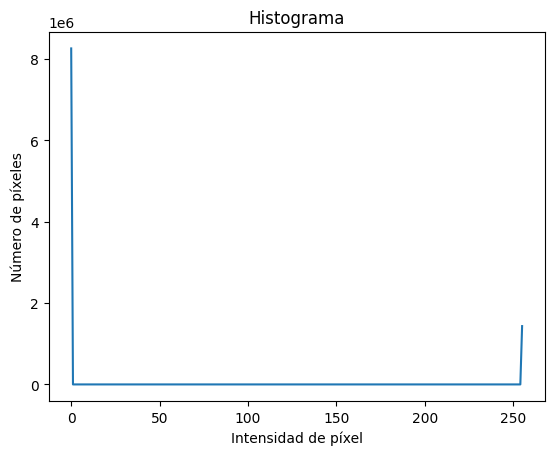

In [4]:
#Cambiar a imagen de un bit, si es menor que el umbral 127 es negro, en otro caso es blanco
_, black_and_white_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

# Resultado
cv2.imshow('Black and White Image', black_and_white_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
histograma = cv2.calcHist([black_and_white_image], [0], None, [256], [0, 256])

# Mostrar el histograma
plt.plot(histograma)
plt.title('Histograma')
plt.xlabel('Intensidad de píxel')
plt.ylabel('Número de píxeles')
plt.show()
#cv2.imwrite('nombre_para_guardar.png',black_and_white_image)

## Dithering aleatorio

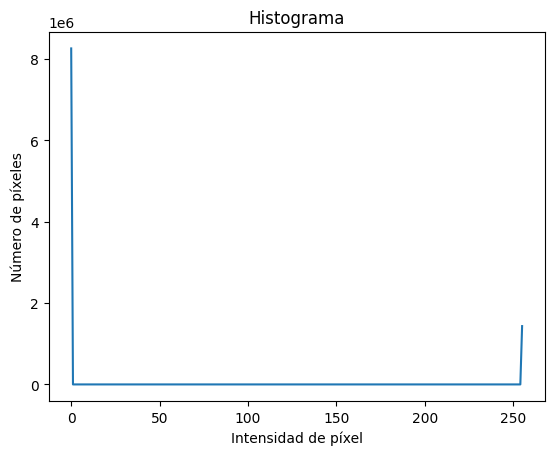

In [5]:
#Cambia la imagen tipo numpy a un objeto image utilizado por PIL
gray_image_pil = Image.fromarray(gray_image)

# Crear una nueva imagen para la salida con dithering, la imagen esta vacia
dithered_im = Image.new('L', gray_image_pil.size)

# Obtener el tamaño de la imagen
width, height = gray_image_pil.size

# Aplicar dithering aleatorio
for x in range(width):
    for y in range(height):
        gray = gray_image_pil.getpixel((x, y)) #Obtiene el valor de gris en la posición actual
        # Aplicar ruido aleatorio
        noisy_gray = gray + random.randint(-128, 127) #Aplica el riudo aleatorio
        # Asegurarse de que el valor esté dentro del rango válido
        noisy_gray = 255 if gray > noisy_gray else 0
        dithered_im.putpixel((x, y), noisy_gray) #Establece el valor en la nueva imagen

# Convertir la imagen dithered de PIL a NumPy para mostrarla con OpenCV
im_dithered_np = np.array(dithered_im)

# Mostrar la imagen con dithering
cv2.imshow('Random dither', im_dithered_np)
cv2.waitKey(0)
cv2.destroyAllWindows()
histograma = cv2.calcHist([im_dithered_np], [0], None, [256], [0, 256])

# Mostrar el histograma
plt.plot(histograma)
plt.title('Histograma')
plt.xlabel('Intensidad de píxel')
plt.ylabel('Número de píxeles')
plt.show()
#cv2.imwrite('nombre_para_guardar.png',im_dithered_np)

## Dithering ordenado 2x2

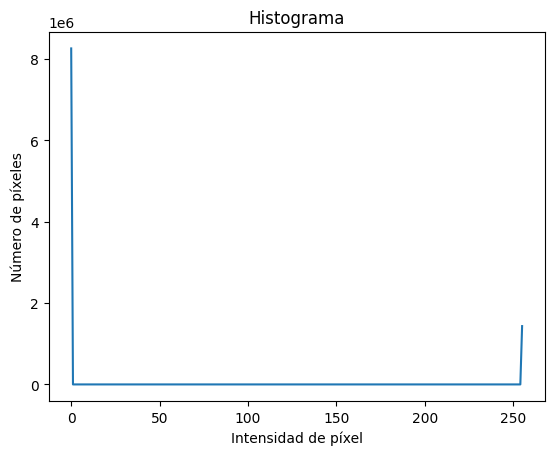

In [15]:
bayer_matrix = np.array([
    [3, 1],
    [0, 2]
]) / 4.0 #Escalar entre 0 y 1
# Obtener las dimensiones de la imagen
height, width = gray_image.shape

# Crear una nueva imagen PIL para el resultado
im_dithered = Image.new('L', (width, height))

# Aplicar dithering ordenado
for y in range(height):
    for x in range(width):
        gray = gray_image[y, x] #Obitene el valor en la posición actual
        threshold = bayer_matrix[y % 2, x % 2] * 255 #Multiplica por el valor de la matriz
        #correspondiente y lo escala en un rango de 0 a 255
        bw = 255 if gray > threshold else 0 #Umbral para determinar si es 0 o 1
        im_dithered.putpixel((x, y), bw) #Agrega el valor a la posición actual

# Convertir la imagen PIL a un array de NumPy para usar con OpenCV
im_dithered_np = np.array(im_dithered)

# Mostrar la imagen usando OpenCV
cv2.imshow("Imagen", im_dithered_np)
cv2.waitKey(0)
cv2.destroyAllWindows()
histograma = cv2.calcHist([im_dithered_np], [0], None, [256], [0, 256])

# Mostrar el histograma
plt.plot(histograma)
plt.title('Histograma')
plt.xlabel('Intensidad de píxel')
plt.ylabel('Número de píxeles')
plt.show()
#cv2.imwrite('nombre_para_guardar.png',im_dithered_np)

## Dithering ordenado 4x4

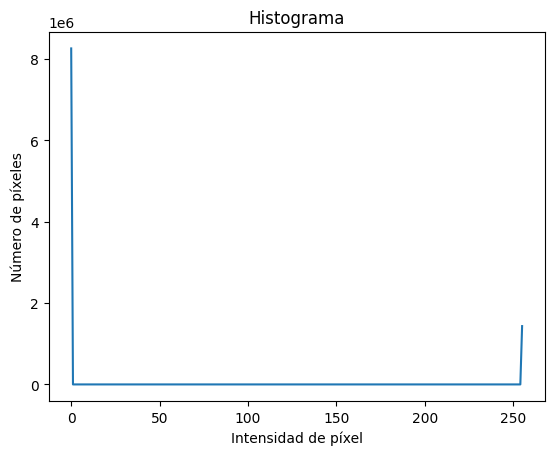

In [19]:
#Es igual que el anterior, solo con la matriz de 4x4
# Matriz de Bayer 4x4
bayer_matrix = np.array([
    [15,7,13,5],
    [3,11,1,9],
    [12,4,14,6],
    [0,8,2,10]
]) / 16.0
height, width = gray_image.shape

# Crear una nueva imagen PIL para el resultado
im_dithered = Image.new('L', (width, height))

# Aplicar dithering ordenado
for y in range(height):
    for x in range(width):
        gray = gray_image[y, x]
        threshold = bayer_matrix[y % 4, x % 4] * 255
        bw = 255 if gray > threshold else 0
        im_dithered.putpixel((x, y), bw)

# Convertir la imagen PIL a un array de NumPy para usar con OpenCV
im_dithered_np = np.array(im_dithered)

# Mostrar la imagen usando OpenCV
cv2.imshow("Imagen", im_dithered_np)
cv2.waitKey(0)
cv2.destroyAllWindows()
histograma = cv2.calcHist([im_dithered_np], [0], None, [256], [0, 256])

# Mostrar el histograma
plt.plot(histograma)
plt.title('Histograma')
plt.xlabel('Intensidad de píxel')
plt.ylabel('Número de píxeles')
plt.show()
#cv2.imwrite('nombre_para_guardar.png',im_dithered_np)

## Dithering con difusión del error de Floyd-Steinberg

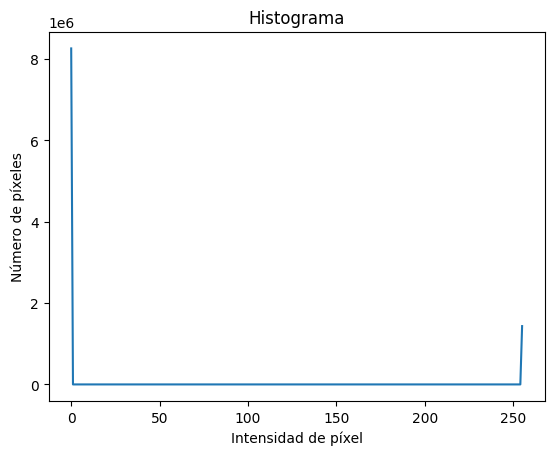

In [17]:
#Convierte la imagen a un formato Image
gray_image_pil = Image.fromarray(gray_image)
#La convierte en un array de numpy
pixels = np.array(gray_image_pil, dtype=np.float32)

# Definir la matriz de difusión de Floyd-Steinberg para distribuir los valores
diffusion_matrix = np.array([[0, 0, 7],
                                [3, 5, 1]]) / 16.0

# Obtener las dimensiones de la imagen
height, width = pixels.shape

for y in range(height):
    for x in range(width):
        old_pixel = pixels[y, x] #Guarda el valor original del pixel
        new_pixel = 255 if old_pixel > 127 else 0 #Umbral para determinar 0 o 1
        pixels[y, x] = new_pixel #Se actualiza el valor del pixel
        error = old_pixel - new_pixel #Calcula la diferencia del valor original al nuevo valor para distribuirlo
        
        # Distribuir el error a los píxeles vecinos
        for dy in range(2):
            for dx in range(-1, 2):
                if 0 <= x + dx < width and 0 <= y + dy < height: #verifica que el los pixeles esten dentro del trango
                    pixels[y + dy, x + dx] += error * diffusion_matrix[dy, dx + 1] #distribuye el error utilizando la matriz

# Convertir los píxeles de vuelta a una imagen PIL
dithered_image_pil = Image.fromarray(pixels.astype(np.uint8))

# Convertir la imagen dithered de PIL a NumPy para mostrarla con OpenCV
dithered_image_np = np.array(dithered_image_pil)

# Mostrar la imagen con dithering
cv2.imshow('Floyd-Steinberg Dither', dithered_image_np)
cv2.waitKey(0)
cv2.destroyAllWindows()
histograma = cv2.calcHist([dithered_image_np], [0], None, [256], [0, 256])

# Mostrar el histograma
plt.plot(histograma)
plt.title('Histograma')
plt.xlabel('Intensidad de píxel')
plt.ylabel('Número de píxeles')
plt.show()
#cv2.imwrite('nombre_para_guardar.png',dithered_image_np)